# Tanzania Water Wells

### Author: Paul Waweru Mbugua
##

## Overview
This project builds a classifier to predict the condition of a water well in Tanzania

## Business Problem
Tanzania, as a developing country, struggles with providing clean water to its population of over 57,000,000. There are many water points already established in the country, but some are in need of repair while others have failed altogether.

The government of Tanzania is focused on locating wells needing repair. 

## Objectives

To predict whether a water pump is working correctly. 

## Data Understanding
This project used data from [Driven Data](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/).

Driven Data runs data science competitions. 

In [2]:
# Import standard packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from xgboost import XGBClassifier

In [3]:
# Loading the training data
df_training_features = pd.read_csv('data\\Training set values.csv')
df_training_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
# Loading the training labels
df_training_labels = pd.read_csv('data\\Training set labels.csv')
df_training_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [5]:
# Combine the df_training_features and the df_training_labels for data preparation
df = pd.merge(df_training_labels, df_training_features, left_on='id', right_on='id', how='left')
df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
# Checking the shape
df.shape

(59400, 41)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [8]:
# Checking the number of entries in each column
df.count()

id                       59400
status_group             59400
amount_tsh               59400
date_recorded            59400
funder                   55765
gps_height               59400
installer                55745
longitude                59400
latitude                 59400
wpt_name                 59400
num_private              59400
basin                    59400
subvillage               59029
region                   59400
region_code              59400
district_code            59400
lga                      59400
ward                     59400
population               59400
public_meeting           56066
recorded_by              59400
scheme_management        55523
scheme_name              31234
permit                   56344
construction_year        59400
extraction_type          59400
extraction_type_group    59400
extraction_type_class    59400
management               59400
management_group         59400
payment                  59400
payment_type             59400
water_qu

In [9]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [10]:
# Checking Nulls
df.isnull().values.any()

True

In [11]:
df.isnull().sum()

id                           0
status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_qu

In [12]:
# Check for duplicates in the id column
df['id'].duplicated().sum()

0

In [13]:
df.value_counts()

id     status_group    amount_tsh  date_recorded  funder                  gps_height  installer         longitude  latitude    wpt_name          num_private  basin                    subvillage  region       region_code  district_code  lga           ward          population  public_meeting  recorded_by              scheme_management  scheme_name                   permit  construction_year  extraction_type  extraction_type_group  extraction_type_class  management  management_group  payment                payment_type  water_quality  quality_group  quantity      quantity_group  source       source_type  source_class  waterpoint_type              waterpoint_type_group
74247  non functional  50.0        2013-02-16     Mission                 965         DWE               35.432998  -10.639270  Kwa Mapunda       0            Ruvuma / Southern Coast  Mpakani     Ruvuma       10           2              Songea Rural  Maposeni      900         True            GeoData Consultants Ltd  VWC      

In [14]:
# Check for the data types
df.dtypes

id                         int64
status_group              object
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment   

### Initial Observations
Some of the columns contain missing values. scheme_name column has the most missing values followed by funder. There are no duplicates in the id column.

Some columns communicate similar information. The basin, subvillage, region, region_code, district_code, lga, and ward communicate the geographic location of the wells. 

Also, the scheme_management and scheme_name communicate who operates the waterpoint.  

extraction_type, extraction_type_group, extraction_type_class relay informaion on the kind of extraction the waterpoint uses 

payment and payment_type tell us what the water costs

quantity and quantity group is the quality of water

source and source type is the source of water

waterpoint_type and water_point_type_group is the kind of water

#### Examining the columns communicating similar information

In [15]:
# Examine the columns about the geographic location
df_location = df[['basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward']]
df_location.head()

,basin,subvillage,region,region_code,district_code,lga,ward
0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi
1,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta
2,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika
3,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu
4,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi


In [16]:
df_location.value_counts()

basin          subvillage            region         region_code  district_code  lga           ward      
Wami / Ruvu    Mtaa Wa Kitunda Kati  Dar es Salaam  7            2              Ilala         Kitunda       84
Pangani        Marurani Kati         Arusha         2            2              Arusha Rural  Nduruma       59
               Marurani Juu          Arusha         2            2              Arusha Rural  Nduruma       54
Wami / Ruvu    Mtaa Wa Vikongoro     Dar es Salaam  7            2              Ilala         Chanika       47
               Vikuge                Pwani          6            2              Kibaha        Soga          41
                                                                                                            ..
Lake Victoria  Nyamwara              Kagera         18           1              Karagwe       Nyakasimbi     1
                                     Mara           20           3              Musoma Rural  Buruma         1
       

In [17]:
df_location.isnull().sum()

basin              0
subvillage       371
region             0
region_code        0
district_code      0
lga                0
ward               0
dtype: int64

In [18]:
for col in df_location.columns:
    print(df_location[col].value_counts())

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64
Madukani    508
Shuleni     506
Majengo     502
Kati        373
Mtakuja     262
           ... 
Buluma        1
Mlandege      1
Ideganja      1
Mazinga       1
Lyungilo      1
Name: subvillage, Length: 19287, dtype: int64
Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam  

The subvillage, lga, and ward columns contain a lot of unique values that might be problematic while generating dummy variables. The region and region_code relay the same information. Therefore, I will drop the subvillage,region_code, lga, and ward from the df.

In [19]:
# Examine the extraction_type, extraction_type_group, and extraction_type_class
df_extraction = df[['extraction_type', 'extraction_type_group', 'extraction_type_class']]
df_extraction.head()

,extraction_type,extraction_type_group,extraction_type_class
0,gravity,gravity,gravity
1,gravity,gravity,gravity
2,gravity,gravity,gravity
3,submersible,submersible,submersible
4,gravity,gravity,gravity


In [20]:
for col in df_extraction.columns:
    print(df[col].value_counts())

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: ext

Given the few unique values in extraction_type_group, I will drop the extraction_type and extraction_type_class

In [21]:
# Examining the payment and payment_type
df_payment = df[['payment', 'payment_type']]
df_payment.head()

,payment,payment_type
0,pay annually,annually
1,never pay,never pay
2,pay per bucket,per bucket
3,never pay,never pay
4,never pay,never pay


In [22]:
df_payment.isnull().sum()

payment         0
payment_type    0
dtype: int64

In [23]:
df_payment.value_counts()

payment                payment_type
never pay              never pay       25348
pay per bucket         per bucket       8985
pay monthly            monthly          8300
unknown                unknown          8157
pay when scheme fails  on failure       3914
pay annually           annually         3642
other                  other            1054
dtype: int64

The columns appear to relay the same information. Thefore, I will drop the payment_type column

In [24]:
# Examining the scheme_management and scheme_name
df_management = df[['scheme_management', 'scheme_name']]
df_management.head()

,scheme_management,scheme_name
0,VWC,Roman
1,Other,NaN
2,VWC,Nyumba ya mungu pipe scheme
3,VWC,NaN
4,NaN,NaN


In [25]:
df_management.isnull().sum()

scheme_management     3877
scheme_name          28166
dtype: int64

The scheme_name column contains a lot of missing values. I will drop this column.

In [26]:
# Examining the water_quality and quality_group
df_quality = df[['water_quality', 'quality_group']]
df_quality.head()

,water_quality,quality_group
0,soft,good
1,soft,good
2,soft,good
3,soft,good
4,soft,good


In [27]:
df_quality.isnull().sum()

water_quality    0
quality_group    0
dtype: int64

The water_quality and quality_group columns do not appear to be similar

In [28]:
# Examine the quantity and quantity_group
df_quantity = df[['quantity', 'quantity_group']]
df_quantity.head()

,quantity,quantity_group
0,enough,enough
1,insufficient,insufficient
2,enough,enough
3,dry,dry
4,seasonal,seasonal


In [29]:
df_quantity.value_counts()

quantity      quantity_group
enough        enough            33186
insufficient  insufficient      15129
dry           dry                6246
seasonal      seasonal           4050
unknown       unknown             789
dtype: int64

In [30]:
df_quantity.isnull().sum()

quantity          0
quantity_group    0
dtype: int64

The quantity and quantity_group appear to be similar. Therefore, I will drop the quantity_group column

In [31]:
# Examine the source, source_type, and source_class columns
df_source = df[['source', 'source_type', 'source_class']]
df_source.head()

,source,source_type,source_class
0,spring,spring,groundwater
1,rainwater harvesting,rainwater harvesting,surface
2,dam,dam,surface
3,machine dbh,borehole,groundwater
4,rainwater harvesting,rainwater harvesting,surface


In [32]:
df_source.isnull().sum()

source          0
source_type     0
source_class    0
dtype: int64

In [33]:
df_source.value_counts()

source                source_type           source_class
spring                spring                groundwater     17021
shallow well          shallow well          groundwater     16824
machine dbh           borehole              groundwater     11075
river                 river/lake            surface          9612
rainwater harvesting  rainwater harvesting  surface          2295
hand dtw              borehole              groundwater       874
lake                  river/lake            surface           765
dam                   dam                   surface           656
other                 other                 unknown           212
unknown               other                 unknown            66
dtype: int64

The source and source_type columns appear to be similar. Also, I will drop the source_class. 

In [34]:
# Examine the water_type and water_type_group
df_waterpoint = df[['waterpoint_type', 'waterpoint_type_group']]
df_waterpoint.head()

,waterpoint_type,waterpoint_type_group
0,communal standpipe,communal standpipe
1,communal standpipe,communal standpipe
2,communal standpipe multiple,communal standpipe
3,communal standpipe multiple,communal standpipe
4,communal standpipe,communal standpipe


In [35]:
df_waterpoint.isnull().sum()

waterpoint_type          0
waterpoint_type_group    0
dtype: int64

In [36]:
df_waterpoint.value_counts()

waterpoint_type              waterpoint_type_group
communal standpipe           communal standpipe       28522
hand pump                    hand pump                17488
other                        other                     6380
communal standpipe multiple  communal standpipe        6103
improved spring              improved spring            784
cattle trough                cattle trough              116
dam                          dam                          7
dtype: int64

The waterpoint_type and waterpoint_type_group appear to be similar. I will drop the waterpoint_type_group column.

### Data Cleaning

First, I will drop all the columns as described above.

I will also drop the columns irrellevant in this exercise.

In [37]:
# I will drop the following columns
columns_to_drop = ['num_private', 'subvillage', 'region', 'lga', 'ward', 'region_code', 'district_code', 'extraction_type', 'extraction_type_group', 'payment_type', 
                   'scheme_name', 'quantity_group', 'source_class', 'waterpoint_type_group', 'id', 'date_recorded', 
                   'recorded_by', 'funder', 'public_meeting', 'wpt_name']


In [38]:
df = df.drop(columns_to_drop, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   gps_height             59400 non-null  int64  
 3   installer              55745 non-null  object 
 4   longitude              59400 non-null  float64
 5   latitude               59400 non-null  float64
 6   basin                  59400 non-null  object 
 7   population             59400 non-null  int64  
 8   scheme_management      55523 non-null  object 
 9   permit                 56344 non-null  object 
 10  construction_year      59400 non-null  int64  
 11  extraction_type_class  59400 non-null  object 
 12  management             59400 non-null  object 
 13  management_group       59400 non-null  object 
 14  payment                59400 non-null  object 
 15  wa

I will investigate the df again

In [39]:
# Checking missing values
df.isnull().sum()

status_group                0
amount_tsh                  0
gps_height                  0
installer                3655
longitude                   0
latitude                    0
basin                       0
population                  0
scheme_management        3877
permit                   3056
construction_year           0
extraction_type_class       0
management                  0
management_group            0
payment                     0
water_quality               0
quality_group               0
quantity                    0
source                      0
source_type                 0
waterpoint_type             0
dtype: int64

In [40]:
# Dropping the missing values
df = df.dropna()
df.head()

,status_group,amount_tsh,gps_height,installer,longitude,latitude,basin,population,scheme_management,permit,...,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,waterpoint_type
0,functional,6000.0,1390,Roman,34.938093,-9.856322,Lake Nyasa,109,VWC,False,...,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,communal standpipe
1,functional,0.0,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,280,Other,True,...,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,communal standpipe
2,functional,25.0,686,World vision,37.460664,-3.821329,Pangani,250,VWC,True,...,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,communal standpipe multiple
3,non functional,0.0,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,58,VWC,True,...,submersible,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,communal standpipe multiple
5,functional,20.0,0,DWE,39.172796,-4.765587,Pangani,1,VWC,True,...,submersible,vwc,user-group,pay per bucket,salty,salty,enough,other,other,communal standpipe multiple


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51319 entries, 0 to 59399
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           51319 non-null  object 
 1   amount_tsh             51319 non-null  float64
 2   gps_height             51319 non-null  int64  
 3   installer              51319 non-null  object 
 4   longitude              51319 non-null  float64
 5   latitude               51319 non-null  float64
 6   basin                  51319 non-null  object 
 7   population             51319 non-null  int64  
 8   scheme_management      51319 non-null  object 
 9   permit                 51319 non-null  object 
 10  construction_year      51319 non-null  int64  
 11  extraction_type_class  51319 non-null  object 
 12  management             51319 non-null  object 
 13  management_group       51319 non-null  object 
 14  payment                51319 non-null  object 
 15  wa

In [42]:
# Check for duplicates
df.duplicated().sum()

1247

In [43]:
# Drop the duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

In [44]:
# Check for inconsitencies 
df.describe()

,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,50072.000000,50072.000000,50072.000000,5.007200e+04,50072.000000,50072.000000
mean,352.466681,709.439407,34.878089,-5.805602e+00,180.649924,1367.204446
std,2797.711886,696.659438,4.241699,2.823288e+00,471.104642,927.903684
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,0.000000
25%,0.000000,0.000000,33.187877,-8.351265e+00,0.000000,0.000000
50%,0.000000,489.000000,35.244605,-5.103877e+00,40.000000,1989.000000
75%,50.000000,1339.000000,37.373558,-3.350084e+00,213.000000,2005.000000
max,250000.000000,2770.000000,40.323402,-2.000000e-08,30500.000000,2013.000000


Many of the above columns contain 0 entries. I will examine them.

In [45]:
# Examining the construction_year
df['construction_year'].value_counts() 

0       15789
2008     2478
2009     2353
2010     2282
2000     1491
2007     1457
2006     1358
2003     1203
2011     1127
2004     1048
1978     1013
2002     1000
2012      947
2005      919
1999      900
1995      864
1998      829
1985      801
1984      722
1982      697
1972      690
1990      652
1994      649
1974      634
1992      604
1996      602
1980      590
1993      513
1997      503
1988      499
2001      491
1983      466
1975      425
1986      403
1976      376
1989      303
1970      303
1991      303
1987      284
1981      221
1973      183
1977      183
1979      173
2013      162
1971      125
1963       84
1967       82
1968       65
1969       59
1960       44
1964       40
1962       28
1961       20
1965       19
1966       16
Name: construction_year, dtype: int64

In [46]:
# Replace the entries containing 0 with the median year
year_median = df['construction_year'].median().astype(int)

df['construction_year'].replace(to_replace=0, value=year_median, inplace=True)


In [47]:
# Examine the construction_year again
df['construction_year'].value_counts()

1989    16092
2008     2478
2009     2353
2010     2282
2000     1491
2007     1457
2006     1358
2003     1203
2011     1127
2004     1048
1978     1013
2002     1000
2012      947
2005      919
1999      900
1995      864
1998      829
1985      801
1984      722
1982      697
1972      690
1990      652
1994      649
1974      634
1992      604
1996      602
1980      590
1993      513
1997      503
1988      499
2001      491
1983      466
1975      425
1986      403
1976      376
1970      303
1991      303
1987      284
1981      221
1977      183
1973      183
1979      173
2013      162
1971      125
1963       84
1967       82
1968       65
1969       59
1960       44
1964       40
1962       28
1961       20
1965       19
1966       16
Name: construction_year, dtype: int64

In [48]:
# Convert permit into interger format
df['permit'] = df['permit'].replace({True:1, False:0})
df.head()

,status_group,amount_tsh,gps_height,installer,longitude,latitude,basin,population,scheme_management,permit,...,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,waterpoint_type
0,functional,6000.0,1390,Roman,34.938093,-9.856322,Lake Nyasa,109,VWC,0,...,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,communal standpipe
1,functional,0.0,1399,GRUMETI,34.698766,-2.147466,Lake Victoria,280,Other,1,...,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,communal standpipe
2,functional,25.0,686,World vision,37.460664,-3.821329,Pangani,250,VWC,1,...,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,communal standpipe multiple
3,non functional,0.0,263,UNICEF,38.486161,-11.155298,Ruvuma / Southern Coast,58,VWC,1,...,submersible,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,communal standpipe multiple
5,functional,20.0,0,DWE,39.172796,-4.765587,Pangani,1,VWC,1,...,submersible,vwc,user-group,pay per bucket,salty,salty,enough,other,other,communal standpipe multiple


In [49]:
# Examining the longitude and latitude
df.longitude.value_counts()



0.000000     447
32.987670      2
33.006275      2
38.340501      2
32.987511      2
            ... 
36.829940      1
39.091919      1
34.714312      1
32.937166      1
35.065137      1
Name: longitude, Length: 49600, dtype: int64

In [50]:
# Drop the rows with 0 enties 
df = df.loc[df['longitude'] != 0]

In [51]:
df.latitude.value_counts()

-2.463910    2
-2.506590    2
-2.487085    2
-2.490324    2
-3.342432    2
            ..
-4.624770    1
-8.778780    1
-7.012233    1
-8.833014    1
-7.841223    1
Name: latitude, Length: 49601, dtype: int64

In [52]:
# Dropping the rows with 0 entries
df = df.loc[df['latitude'] != 0]

In [53]:
# Examine the df again
df.describe()

,amount_tsh,gps_height,longitude,latitude,population,permit,construction_year
count,49625.000000,49625.000000,49625.000000,49625.000000,49625.000000,49625.000000,49625.000000
mean,355.641545,715.829723,35.192255,-5.857896,182.277139,0.689290,1994.436252
std,2810.083265,696.513939,2.664138,2.781441,472.908181,0.462789,11.046675
min,0.000000,-90.000000,29.607122,-11.649440,0.000000,0.000000,1960.000000
25%,0.000000,0.000000,33.240410,-8.405406,0.000000,0.000000,1989.000000
50%,0.000000,511.000000,35.292537,-5.142893,40.000000,1.000000,1989.000000
75%,50.000000,1343.000000,37.389366,-3.363819,220.000000,1.000000,2005.000000
max,250000.000000,2770.000000,40.323402,-0.998464,30500.000000,1.000000,2013.000000


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49625 entries, 0 to 59399
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           49625 non-null  object 
 1   amount_tsh             49625 non-null  float64
 2   gps_height             49625 non-null  int64  
 3   installer              49625 non-null  object 
 4   longitude              49625 non-null  float64
 5   latitude               49625 non-null  float64
 6   basin                  49625 non-null  object 
 7   population             49625 non-null  int64  
 8   scheme_management      49625 non-null  object 
 9   permit                 49625 non-null  int64  
 10  construction_year      49625 non-null  int64  
 11  extraction_type_class  49625 non-null  object 
 12  management             49625 non-null  object 
 13  management_group       49625 non-null  object 
 14  payment                49625 non-null  object 
 15  wa

In [55]:
# Check the unique values
df.nunique()

status_group                 3
amount_tsh                  95
gps_height                2426
installer                 1882
longitude                49599
latitude                 49601
basin                        9
population                1012
scheme_management           12
permit                       2
construction_year           54
extraction_type_class        7
management                  12
management_group             5
payment                      7
water_quality                8
quality_group                6
quantity                     5
source                      10
source_type                  7
waterpoint_type              7
dtype: int64

The installer entries are objects, and has too many unique values, meaning it will be problematic 
while creating the dummy variables. I will examine the column again.

In [56]:
df['installer'].value_counts()

DWE                    14179
Government              1616
Commu                   1060
DANIDA                  1046
RWE                     1004
                       ...  
Fin Water                  1
TRC                        1
Mwananchi Engineeri        1
QUICKWINS                  1
MECO                       1
Name: installer, Length: 1882, dtype: int64

After examining the installer column further in Excel, I realized it has too many variation of the same installer. I will drop this colum. 

In [57]:
df = df.drop('installer', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49625 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           49625 non-null  object 
 1   amount_tsh             49625 non-null  float64
 2   gps_height             49625 non-null  int64  
 3   longitude              49625 non-null  float64
 4   latitude               49625 non-null  float64
 5   basin                  49625 non-null  object 
 6   population             49625 non-null  int64  
 7   scheme_management      49625 non-null  object 
 8   permit                 49625 non-null  int64  
 9   construction_year      49625 non-null  int64  
 10  extraction_type_class  49625 non-null  object 
 11  management             49625 non-null  object 
 12  management_group       49625 non-null  object 
 13  payment                49625 non-null  object 
 14  water_quality          49625 non-null  object 
 15  qu

In [58]:
df.nunique()

status_group                 3
amount_tsh                  95
gps_height                2426
longitude                49599
latitude                 49601
basin                        9
population                1012
scheme_management           12
permit                       2
construction_year           54
extraction_type_class        7
management                  12
management_group             5
payment                      7
water_quality                8
quality_group                6
quantity                     5
source                      10
source_type                  7
waterpoint_type              7
dtype: int64

### Exprolatory Data Analysis (EDA)

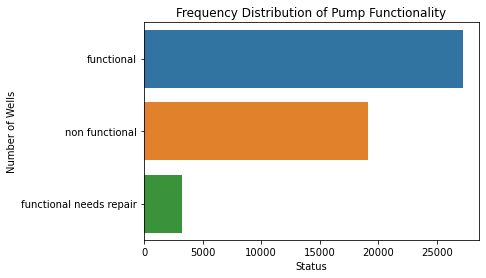

In [59]:
# Bar plot for the target feature
plt.figure()
sns.countplot(data=df, y='status_group', order=df['status_group'].value_counts().index)
plt.xlabel('Status')
plt.ylabel('Number of Wells')
plt.title('Frequency Distribution of Pump Functionality')
plt.show()

Most pumps are functional.

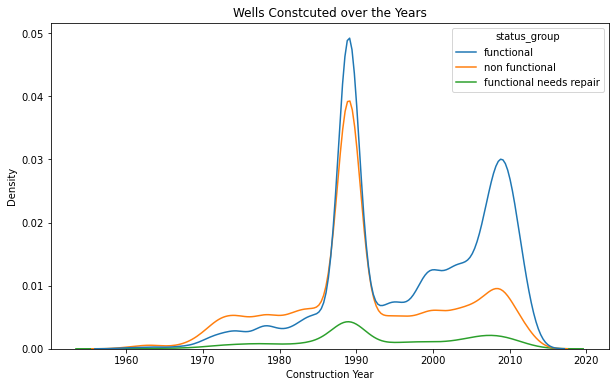

In [60]:
# Number of wells constructed over the years
plt.figure(figsize=(10,6))
sns.kdeplot(data=df, hue='status_group', x='construction_year')
plt.xlabel('Construction Year')
plt.ylabel('Density')
plt.title("Wells Constcuted over the Years")
plt.show()

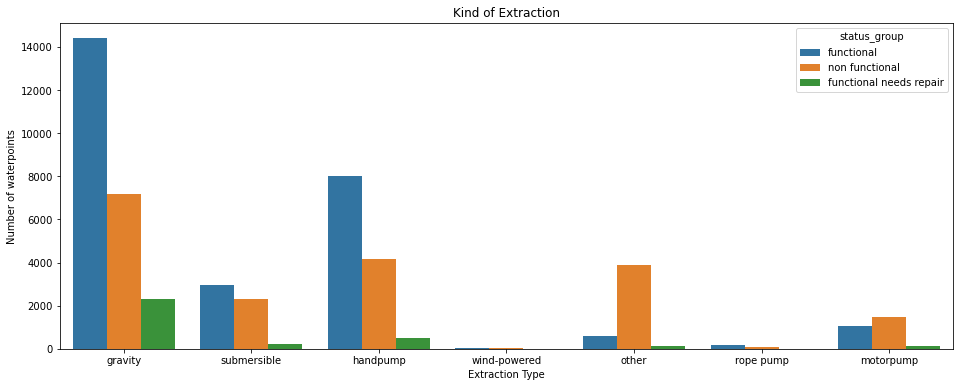

In [61]:
# Extraction
plt.figure(figsize=(16,6))
sns.countplot(data=df, x='extraction_type_class', hue='status_group')
plt.xlabel('Extraction Type')
plt.ylabel('Number of waterpoints')
plt.title('Kind of Extraction')
plt.show()

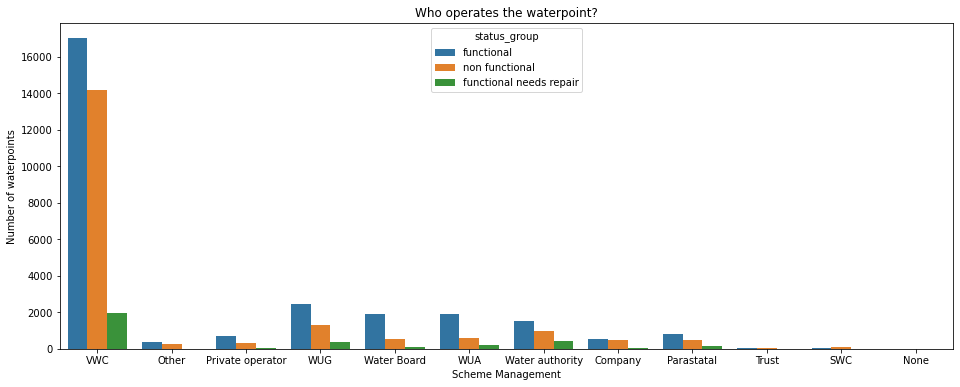

In [62]:
# Scheme_management
plt.figure(figsize=(16,6))
sns.countplot(data=df, x='scheme_management', hue='status_group')
plt.xlabel('Scheme Management')
plt.ylabel('Number of waterpoints')
plt.title('Who operates the waterpoint?')
plt.show()

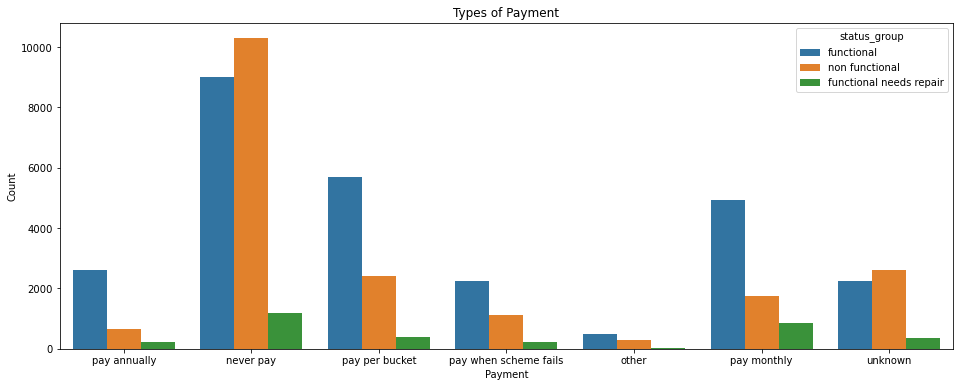

In [63]:
# Payment
plt.figure(figsize=(16,6))
sns.countplot(data=df, x='payment', hue='status_group')
plt.xlabel('Payment')
plt.ylabel('Count')
plt.title('Types of Payment')
plt.show()

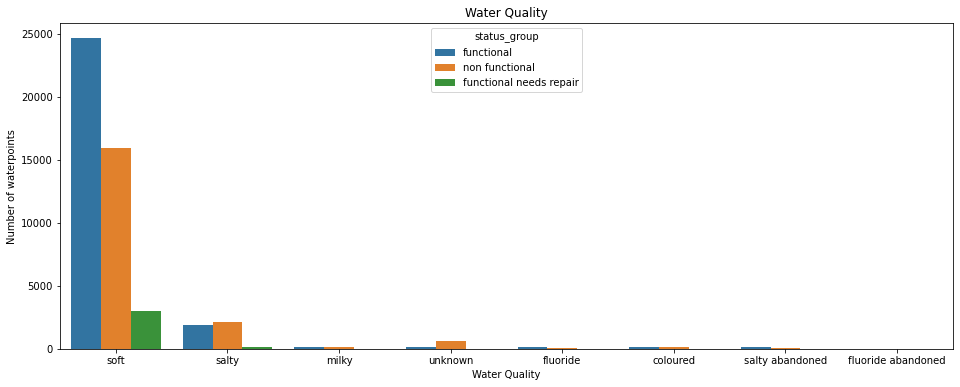

In [64]:
# Quality
plt.figure(figsize=(16,6))
sns.countplot(data=df, x='water_quality', hue='status_group')
plt.xlabel('Water Quality')
plt.ylabel('Number of waterpoints')
plt.title('Water Quality')
plt.show()

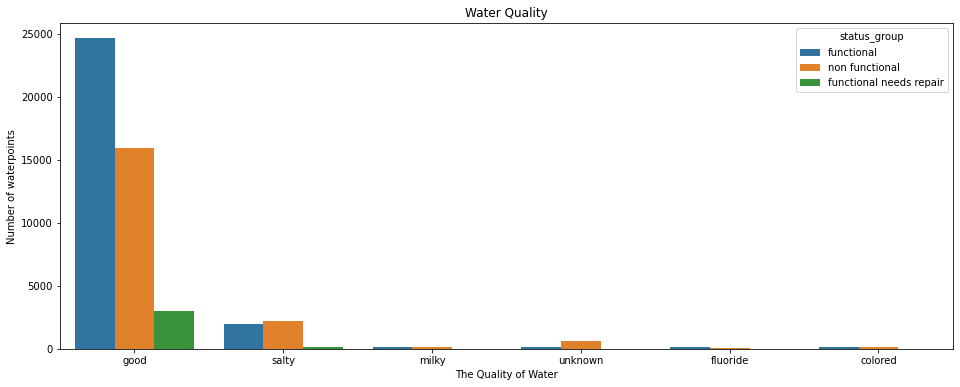

In [65]:
# Quality group
plt.figure(figsize=(16,6))
sns.countplot(data=df, x='quality_group', hue='status_group')
plt.xlabel('The Quality of Water')
plt.ylabel('Number of waterpoints')
plt.title('Water Quality')
plt.show()

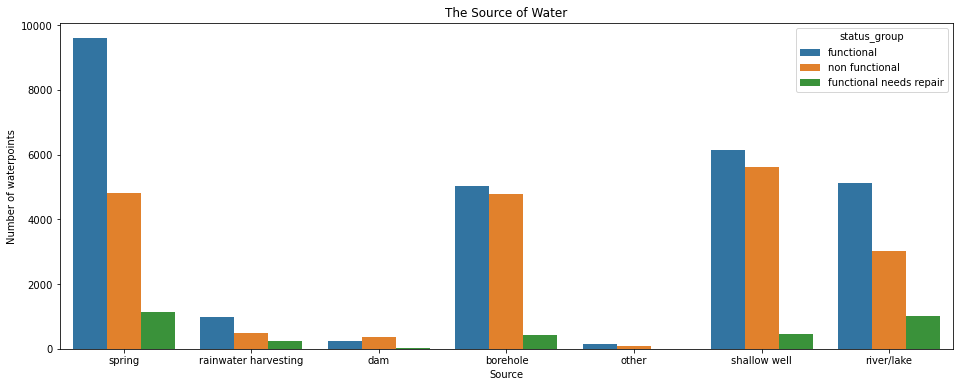

In [66]:
# Scheme_management
plt.figure(figsize=(16,6))
sns.countplot(data=df, x='source_type', hue='status_group')
plt.xlabel('Source')
plt.ylabel('Number of waterpoints')
plt.title('The Source of Water')
plt.show()

### Modeling

To start out, I will define the y, which is the status_group and X, which is everything else. 

In [67]:
# First, we have to change the status_group into numeric values
df['pump_status'] = df['status_group'].map({'non functional':0, 'functional needs repair':1, 'functional':2})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49625 entries, 0 to 59399
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           49625 non-null  object 
 1   amount_tsh             49625 non-null  float64
 2   gps_height             49625 non-null  int64  
 3   longitude              49625 non-null  float64
 4   latitude               49625 non-null  float64
 5   basin                  49625 non-null  object 
 6   population             49625 non-null  int64  
 7   scheme_management      49625 non-null  object 
 8   permit                 49625 non-null  int64  
 9   construction_year      49625 non-null  int64  
 10  extraction_type_class  49625 non-null  object 
 11  management             49625 non-null  object 
 12  management_group       49625 non-null  object 
 13  payment                49625 non-null  object 
 14  water_quality          49625 non-null  object 
 15  qu

In [68]:
df = df.drop('status_group', axis=1)
df.head()

,amount_tsh,gps_height,longitude,latitude,basin,population,scheme_management,permit,construction_year,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,waterpoint_type,pump_status
0,6000.0,1390,34.938093,-9.856322,Lake Nyasa,109,VWC,0,1999,gravity,vwc,user-group,pay annually,soft,good,enough,spring,spring,communal standpipe,2
1,0.0,1399,34.698766,-2.147466,Lake Victoria,280,Other,1,2010,gravity,wug,user-group,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,communal standpipe,2
2,25.0,686,37.460664,-3.821329,Pangani,250,VWC,1,2009,gravity,vwc,user-group,pay per bucket,soft,good,enough,dam,dam,communal standpipe multiple,2
3,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,58,VWC,1,1986,submersible,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,communal standpipe multiple,0
5,20.0,0,39.172796,-4.765587,Pangani,1,VWC,1,2009,submersible,vwc,user-group,pay per bucket,salty,salty,enough,other,other,communal standpipe multiple,2


#### Baseline Model - Logistic Regression 

##### Preprocessing 

Creating dummies and transforming the data

In [69]:
def preprocess_data(X):
    
    # Dummy variables
    X_categorical = X.select_dtypes(exclude=['int64', 'float64']).copy() 
    
    X_dummy = pd.get_dummies(X_categorical, drop_first=True) 
    
    # Normalize the numeric features
    X_numerical = X.select_dtypes(include=['int64', 'float64']).copy()
  
    # Combine the dataframes
    X_full = pd.concat([X_dummy, X_numerical], axis=1)
    return X_full    
    


In [70]:
df_dummy = preprocess_data(df)
df_dummy.head()

,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,scheme_management_None,scheme_management_Other,...,waterpoint_type_improved spring,waterpoint_type_other,amount_tsh,gps_height,longitude,latitude,population,permit,construction_year,pump_status
0,1,0,0,0,0,0,0,0,0,0,...,0,0,6000.0,1390,34.938093,-9.856322,109,0,1999,2
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0.0,1399,34.698766,-2.147466,280,1,2010,2
2,0,0,0,0,1,0,0,0,0,0,...,0,0,25.0,686,37.460664,-3.821329,250,1,2009,2
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0.0,263,38.486161,-11.155298,58,1,1986,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,20.0,0,39.172796,-4.765587,1,1,2009,2


Train-Test Split

In [71]:
# Assigning X to the dependent variables and y to target variables
y = df_dummy['pump_status'] 
X = df_dummy.drop('pump_status', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Constructing a Pipeline 

In [72]:
# Transformer = FunctionTransformer(preprocess_data)

In [73]:
pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('logreg', LogisticRegression(multi_class='multinomial', 
                                                     solver='newton-cg', random_state=42))])

In [74]:
# Fit the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(multi_class='multinomial', random_state=42,
                                    solver='newton-cg'))])

In [75]:
pipe.score(X_train, y_train)

0.737465742382718

The baseline model's accuracy was 73.75%. It is a good start. 

In [76]:
# Checking for accuracy of training and test data
test_preds = pipe.predict(X_test)


In [77]:
# function to track model metrics and plot confusion matrix

def model_score(model, X, y_pred, y_true):
    target_names= ['non functional', 'functional but need repair', 'functional']
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    #Confusion matrix    
    return plot_confusion_matrix(model, X, y_true, display_labels=target_names);

                            precision    recall  f1-score   support

            non functional       0.80      0.62      0.70      4830
functional but need repair       0.43      0.05      0.08       810
                functional       0.72      0.90      0.80      6767

                  accuracy                           0.74     12407
                 macro avg       0.65      0.52      0.53     12407
              weighted avg       0.73      0.74      0.71     12407



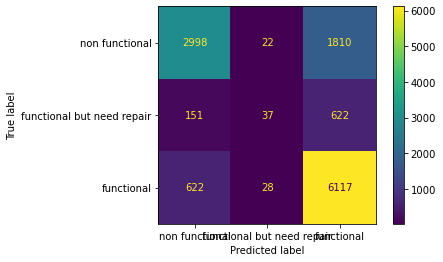

In [78]:
score = model_score(pipe, X_test, test_preds, y_test)

In [79]:
# Cross validation 
cross_validate(pipe, X_train, y_train, cv=10)['test_score']

array([0.74476088, 0.74073079, 0.73481999, 0.72434175, 0.72514777,
       0.7514777 , 0.73293928, 0.73992477, 0.72910508, 0.7358237 ])

### Decision Tree Model

I will first create a baseline Decision Trees model

In [80]:
pipe_dt = Pipeline(steps=[('scaler', StandardScaler()),
                       ('dt_clf', DecisionTreeClassifier())])

                            precision    recall  f1-score   support

            non functional       0.76      0.76      0.76      4830
functional but need repair       0.33      0.32      0.33       810
                functional       0.80      0.80      0.80      6767

                  accuracy                           0.75     12407
                 macro avg       0.63      0.63      0.63     12407
              weighted avg       0.75      0.75      0.75     12407



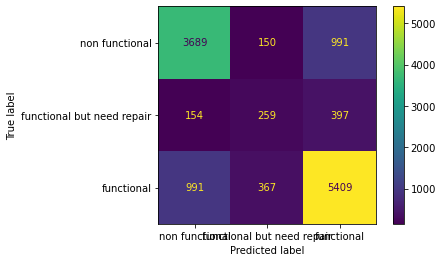

In [81]:
# Fitting and predicting 
pipe_dt.fit(X_train, y_train)
test_preds = pipe_dt.predict(X_test)
dt_score = model_score(pipe_dt, X_test, test_preds, y_test)

In [82]:
# Prediction on test data
train_preds = pipe_dt.predict(X_train)

# Accuracy
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f'Training accuracy: {train_accuracy*100}')
print(f'Test accuracy: {test_accuracy*100}')

Training accuracy: 100.0
Test accuracy: 75.41710324816636


The model is overfitting given the training accuracy of 100% and test accuracy of 75.49

In [83]:
# Cross validation
cross_validate(pipe_dt, X_train, y_train, cv=5)['test_score']

array([0.74919398, 0.74543256, 0.75120903, 0.74150208, 0.75547494])

Feature importance

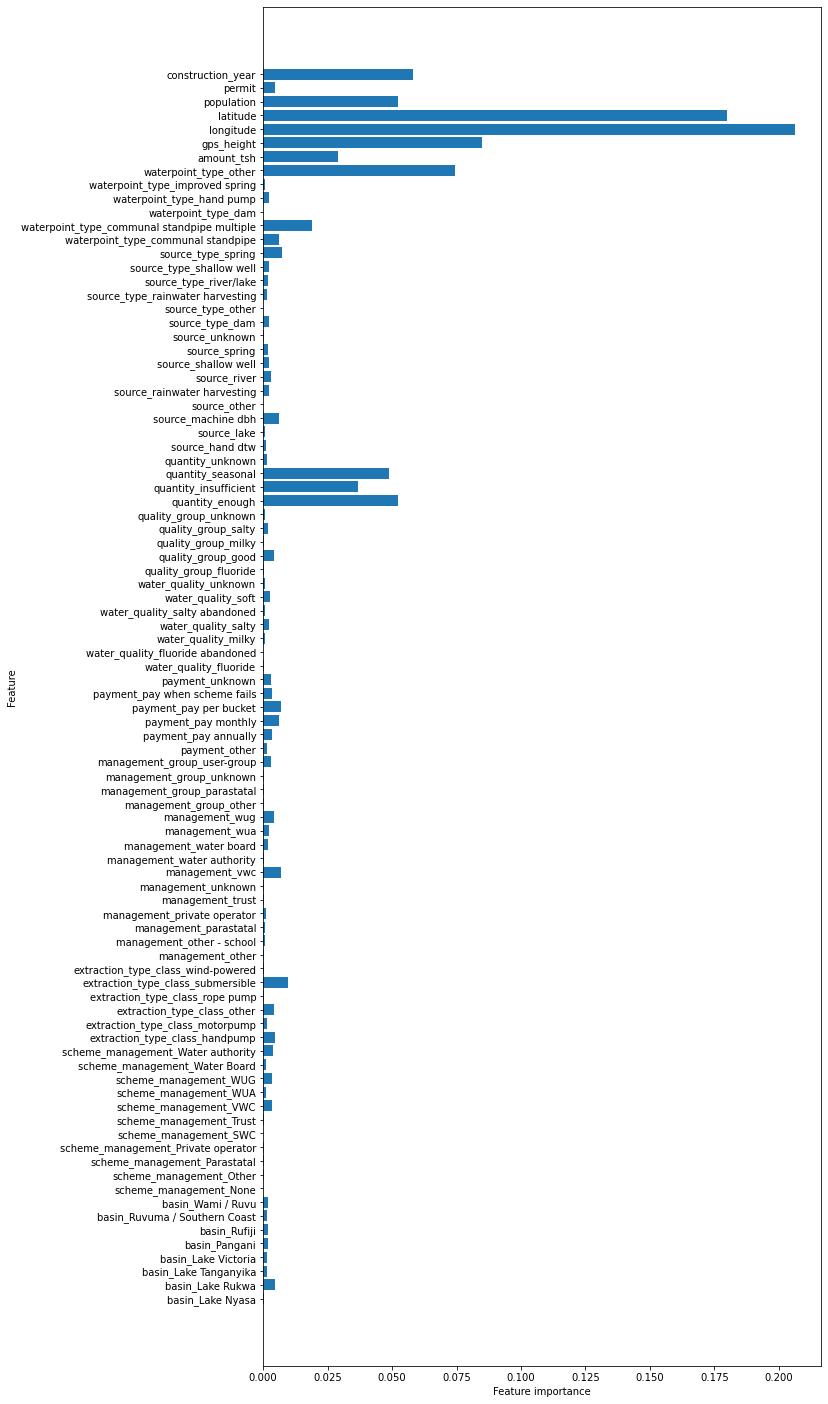

In [84]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(10,25))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    
plot_feature_importances(dt_clf)

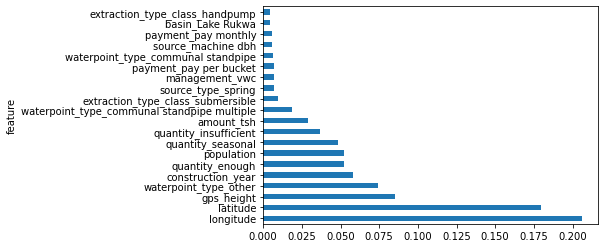

In [85]:
# Main features
feature_importances=pd.DataFrame(columns=['feature','importance'])

feature_importances['feature']= X_train.columns

feature_importances['importance']=dt_clf.feature_importances_

feature_importances= feature_importances.set_index('feature')

feature_importances['importance'].sort_values(ascending = False).head(20).plot(kind='barh');

The longitude, latitude, gps_height, and construction_year are the most important features

GridSearchCV

In [86]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 20, 30, 40, 50, 60],
    'min_samples_split': [2, 5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 5, 10, 15, 20, 30],   
}

dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 20, 30, 40, 50, 60],
                         'min_samples_leaf': [1, 5, 10, 15, 20, 30],
                         'min_samples_split': [2, 5, 10, 15, 20, 25]},
             return_train_score=True)

In [87]:
# Examine the parameters
 
# Mean training score
dt_gs_training_score = np.mean(dt_grid_search.cv_results_['mean_train_score'])

# Mean test score
dt_gs_testing_score = dt_grid_search.score(X_test, y_test)

print(f"Mean Training Score: {dt_gs_training_score :.2%}")
print(f"Mean Test Score: {dt_gs_testing_score :.2%}")
print("Best Parameter Combination Found During Grid Search:", dt_grid_search.best_params_)

Mean Training Score: 83.34%
Mean Test Score: 76.99%
Best Parameter Combination Found During Grid Search: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 15, 'min_samples_split': 20}


The GridSeacrchCV has improved the model perfromance. There close training and test scores indicate that there are no signs of overfitting. However, the model is as good as the combination of parameters included in the parameter grid. 

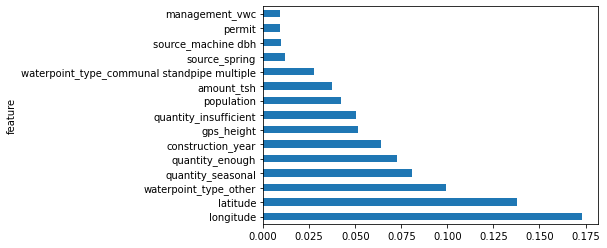

In [88]:
feature_importances=pd.DataFrame(columns=['feature','importance'])

feature_importances['feature']= X_train.columns

feature_importances['importance']=dt_grid_search.best_estimator_.feature_importances_

feature_importances= feature_importances.set_index('feature')

feature_importances['importance'].sort_values(ascending = False).head(15).plot(kind='barh');

### Random Forests

In [89]:
# Baseline random forest classifier 

rf_clf = RandomForestClassifier()
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X_train, y_train, cv=3))

print(
    f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}"
)

Mean Cross Validation Score for Random Forest Classifier: 79.37%


In [91]:
# Model tuning 
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3, return_train_score=True)
rf_grid_search.fit(X_train, y_train)

print(f"Testing Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Testing Accuracy: 79.31%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
# best_parameters = rf_grid_search.best_params_

# print('Grid Search found the following optimal parameters: ')
# for param_name in sorted(best_parameters.keys()):
#     print('%s: %r' % (param_name, best_parameters[param_name]))

# training_preds = rf_grid_search.predict(X_train)
# test_preds = rf_grid_search.predict(X_test)
# training_accuracy = accuracy_score(y_train, training_preds)
# test_accuracy = accuracy_score(y_test, test_preds)

# print('')
# print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
# print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

: 

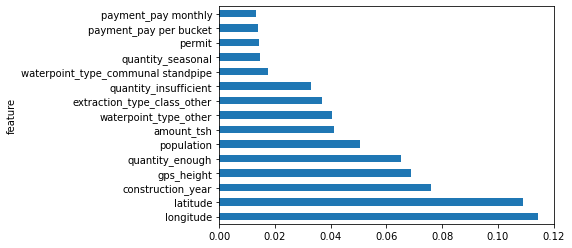

In [93]:
# Important Features
feature_importances=pd.DataFrame(columns=['feature','importance'])

feature_importances['feature']= X_train.columns

feature_importances['importance']=rf_grid_search.best_estimator_.feature_importances_

feature_importances= feature_importances.set_index('feature')

feature_importances['importance'].sort_values(ascending = False).head(15).plot(kind='barh');

### XG Boost

In [94]:
# Baseline model
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 85.14%
Validation accuracy: 79.68%


In [95]:
# Model tuning 
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.2
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.5

Training Accuracy: 83.63%
Validation accuracy: 79.48%


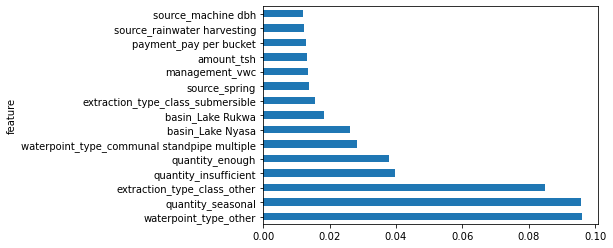

In [96]:
# Important Features
feature_importances=pd.DataFrame(columns=['feature','importance'])

feature_importances['feature']= X_train.columns

feature_importances['importance']=grid_clf.best_estimator_.feature_importances_ 

feature_importances= feature_importances.set_index('feature')

feature_importances['importance'].sort_values(ascending = False).head(15).plot(kind='barh');